# References
* https://keras.io/examples/generative/wgan_gp/
* https://github.com/julianzaidi/Project-IFT6266/blob/master/DCGAN/model.py
* https://www.tensorflow.org/tutorials/generative/dcgan

# Imports

In [1]:
import os
import glob
import time
import imageio

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing, optimizers

# Load Dataset

In [13]:
batch_size = 256
img_dim = 64
channels = 3
img_shape = (img_dim, img_dim, channels)

dataset = preprocessing.image_dataset_from_directory(
  'input_images/celebrity_faces',
  image_size=(img_dim, img_dim),
  batch_size=batch_size,
  interpolation='area',
  validation_split=0.25,
  subset='validation',
  seed=1234,
)
dataset = dataset.map(lambda x, _: (x - 127.5) / 127.5)

Found 202599 files belonging to 1 classes.
Using 50649 files for validation.


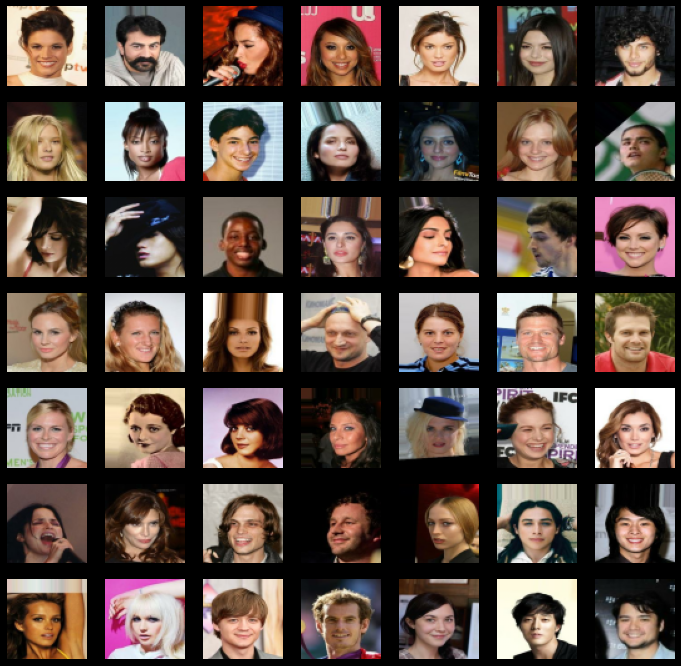

In [14]:
num_examples = 49

X = []
while len(X) < num_examples:
  X += list(dataset.as_numpy_iterator().next())

fig = plt.figure(figsize=(12, 12))
for i in range(num_examples):
  grid_size = int(np.ceil(np.sqrt(num_examples)))
  fig.add_subplot(grid_size, grid_size, i + 1)
  plt.imshow(X[i] * 0.5 + 0.5)
  plt.axis('off')

# Create WGAN-GP

Create generator

In [15]:
noise_dim = 256

generator = models.Sequential([
  layers.Reshape(target_shape=(1, 1, noise_dim), input_shape=(noise_dim,)),

  layers.Conv2DTranspose(filters=256, kernel_size=4, strides=4, use_bias=False),
  layers.BatchNormalization(),
  layers.LeakyReLU(0.2),
  layers.Conv2DTranspose(filters=256, kernel_size=3, padding='same', use_bias=False),
  layers.BatchNormalization(),
  layers.LeakyReLU(0.2),

  layers.UpSampling2D(),
  layers.Conv2DTranspose(filters=128, kernel_size=3, padding='same', use_bias=False),
  layers.BatchNormalization(),
  layers.LeakyReLU(0.2),
  layers.Conv2DTranspose(filters=128, kernel_size=3, padding='same', use_bias=False),
  layers.BatchNormalization(),
  layers.LeakyReLU(0.2),

  layers.UpSampling2D(),
  layers.Conv2DTranspose(filters=64, kernel_size=3, padding='same', use_bias=False),
  layers.BatchNormalization(),
  layers.LeakyReLU(0.2),
  layers.Conv2DTranspose(filters=64, kernel_size=3, padding='same', use_bias=False),
  layers.BatchNormalization(),
  layers.LeakyReLU(0.2),

  layers.UpSampling2D(),
  layers.Conv2DTranspose(filters=32, kernel_size=3, padding='same', use_bias=False),
  layers.BatchNormalization(),
  layers.LeakyReLU(0.2),
  layers.Conv2DTranspose(filters=32, kernel_size=3, padding='same', use_bias=False),
  layers.BatchNormalization(),
  layers.LeakyReLU(0.2),

  layers.UpSampling2D(),
  layers.Conv2DTranspose(filters=16, kernel_size=3, padding='same', use_bias=False),
  layers.BatchNormalization(),
  layers.LeakyReLU(0.2),
  layers.Conv2DTranspose(filters=16, kernel_size=3, padding='same', use_bias=False),
  layers.BatchNormalization(),
  layers.LeakyReLU(0.2),

  layers.Conv2DTranspose(filters=3, kernel_size=1, padding='same', use_bias=False, activation='tanh'),
])

generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 4, 4, 256)         1048576   
_________________________________________________________________
batch_normalization_20 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_23 (Conv2DT (None, 4, 4, 256)         589824    
_________________________________________________________________
batch_normalization_21 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 4, 4, 256)        

Create critic (similar to discriminator in DCGANs)

In [16]:
critic = models.Sequential([
  layers.Conv2D(filters=16, kernel_size=1, padding='same',use_bias=False, input_shape=img_shape),
  layers.LeakyReLU(0.2),
  layers.Conv2D(filters=16, kernel_size=3, padding='same', use_bias=False),
  layers.LeakyReLU(0.2),
  layers.Conv2D(filters=32, kernel_size=3, padding='same', use_bias=False),
  layers.LeakyReLU(0.2),
  layers.MaxPool2D(),

  layers.Conv2D(filters=32, kernel_size=3, padding='same', use_bias=False),
  layers.LeakyReLU(0.2),
  layers.Conv2D(filters=64, kernel_size=3, padding='same', use_bias=False),
  layers.LeakyReLU(0.2),
  layers.MaxPool2D(),

  layers.Conv2D(filters=64, kernel_size=3, padding='same', use_bias=False),
  layers.LeakyReLU(0.2),
  layers.Conv2D(filters=128, kernel_size=3, padding='same', use_bias=False),
  layers.LeakyReLU(0.2),
  layers.MaxPool2D(),

  layers.Conv2D(filters=128, kernel_size=3, padding='same', use_bias=False),
  layers.LeakyReLU(0.2),
  layers.Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False),
  layers.LeakyReLU(0.2),
  layers.MaxPool2D(),

  layers.Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False),
  layers.LeakyReLU(0.2),
  layers.Conv2D(filters=noise_dim, kernel_size=4, strides=4, use_bias=False),
  layers.LeakyReLU(0.2),

  layers.Flatten(),
  layers.Dense(1),
])
critic.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 64, 64, 16)        48        
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 16)        2304      
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 64, 64, 32)        4608      
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 32)       

# Training

Wasserstein Gradient Penalty Loss (Critic and Generator Losses)

$L_C=\mathbb{E}[C(G(z))]-\mathbb{E}[C(x)]+\lambda\mathbb{E}[(||\nabla C(i)||_2-1)^2]$

$L_G=-\mathbb{E}[C(G(z))]$

Where

* $C$ is the critic

* $G$ is the generator

* $x$ is sampled from the distribution of real images

* $z$ is random noise such that $z\sim\mathcal{N}(0,1)$

* $i$ is an interpolation between real and fake images defined as $i=\alpha x-(1-\alpha)G(z)$ where $\alpha\sim\mathcal{U}(0,1)$

* $C(x)$ is the critic's score for an input real image $x$

* $G(z)$ is an image generated using noise $z$

* $C(G(z))$ is the critic's score for an input fake image $G(z)$

* $\lambda$ is the penalty amount hyperparameter (the code uses $\lambda=10$)

Loss Explanations

* The critic is trying to minimize $L_C$, which is equivalent to maximizing $\mathbb{E}[C(x)]$ and minimizing $\mathbb{E}[C(G(z))]$. The critic is trying to give the real images higher scores than the fake images.

* The generator is trying to minimize $L_G$, which is equivalent to maximizing $\mathbb{E}[C(G(z))]$. The generator is trying to trick the critic into giving fake images high scores.

* A penalty $\lambda\mathbb{E}[(||\nabla C(i)||_2-1)^2]$ is added to the critic loss to prevent the gradient of the critic from growing too large.

In [17]:
num_examples = 49 # number of generated images to show each epoch

generator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.99)
critic_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.99)
generator_losses, critic_losses = [], []
seed = tf.random.normal([num_examples, noise_dim])

dataset_name = 'faces'
checkpoint_dir = f'checkpoints/{dataset_name}'
output_dir = f'output_images/{dataset_name}'
losses_dir = f'losses/{dataset_name}'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
  generator_optimizer=generator_optimizer,
  critic_optimizer=critic_optimizer,
  generator=generator,
  critic=critic,
)

def train(dataset, epochs, restore_epoch=0, save_freq=20):
  mkdir('seeds')
  np.save(f'seeds/{dataset_name}_seed.npy', seed)

  avg_time_per_epoch = 0
  for epoch in range(restore_epoch, epochs):
    start = time.time()

    for image_batch in dataset:
      critic_loss = train_critic(image_batch)
      generator_loss = train_generator(len(image_batch))

    generator_losses.append(generator_loss)
    critic_losses.append(critic_loss)

    mkdir(losses_dir)
    np.save(f'{losses_dir}/generator_losses.npy', generator_losses)
    np.save(f'{losses_dir}/critic_losses.npy', critic_losses)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)
    print(f'Generator Loss: {round(float(generator_loss), 3)} | Critic Loss: {round(float(critic_loss), 3)}')

    if (epoch + 1) % save_freq == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    avg_time_per_epoch = print_time(start, epoch, epochs, restore_epoch, avg_time_per_epoch)


def train_critic(real_images):
  noise = tf.random.normal([len(real_images), noise_dim]) # z
  with tf.GradientTape() as critic_tape:
    fake_images = generator(noise, training=True) # G(z)

    real_output = critic(real_images, training=True) # C(x)
    fake_output = critic(fake_images, training=True) # C(G(z))
    
    critic_loss_unpenalized = get_critic_loss(real_output, fake_output) # E[C(G(z))] - E[C(x)]
    penalty = get_gradient_penalty(real_images, fake_images) # E[(||∇C(i)||₂ - 1)²]
    critic_loss = critic_loss_unpenalized + 10.0 * penalty # E[C(G(z))] - E[C(x)] + λ * E[(||∇C(i)||₂ - 1)²]

  gradients_of_critic = critic_tape.gradient(critic_loss, critic.trainable_variables)
  critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))
  return critic_loss


def train_generator(batch_size):
  noise = tf.random.normal([batch_size, noise_dim])
  with tf.GradientTape() as generator_tape:
    fake_images = generator(noise, training=True) # G(z)
    fake_output = critic(fake_images, training=True) # C(G(z))
    generator_loss = get_generator_loss(fake_output) # -E[C(G(z))]

  gradients_of_generator = generator_tape.gradient(generator_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  return generator_loss


# E[C(G(z))] - E[C(x)]
def get_critic_loss(real_output, fake_output):
  return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)


# -E[C(G(z))]
def get_generator_loss(fake_output):
  return -tf.reduce_mean(fake_output)


# E[(||∇C(i)||₂ - 1)²]
def get_gradient_penalty(real_images, fake_images):
  alpha = tf.random.normal((len(real_images), 1, 1, 1))
  interpolated = alpha * real_images + (1 - alpha) * fake_images # i = α * x + (1 - α) * G(z)

  with tf.GradientTape() as penalty_tape:
    penalty_tape.watch(interpolated)
    interpolated_output = critic(interpolated, training=True)

  grads = penalty_tape.gradient(interpolated_output, [interpolated])[0] # ∇C(i)
  norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=(1, 2, 3))) # ||∇C(i)||₂
  penalty = tf.reduce_mean((norm - 1.0) ** 2) # E[(||∇C(i)||₂ - 1)²]
  return penalty


def generate_and_save_images(model, epoch, test_input):
  mkdir(output_dir)
  predictions = model(test_input, training=False)
  plt.figure(figsize=(12, 12))
  grid_size = int(np.ceil(np.sqrt(num_examples)))
  for i in range(predictions.shape[0]):
    plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(predictions[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig('{}/image_at_epoch_{:04d}.png'.format(output_dir, epoch))
  plt.show()


def print_time(epoch_start, epoch, total_epochs, restore_epoch, avg_time_per_epoch):
  time_for_epoch = time.time() - epoch_start
  epoch_adj = epoch - restore_epoch
  avg_time_per_epoch = (avg_time_per_epoch * epoch_adj + time_for_epoch) / (epoch_adj + 1)
  remaining_epochs = total_epochs - (epoch + 1)
  
  time_for_epoch_string = get_time_string(time_for_epoch)
  remaining_time_string = get_time_string(remaining_epochs * avg_time_per_epoch)

  print(f'Time For Epoch {epoch + 1}: {time_for_epoch_string}')
  print(f'Remaining Time: {remaining_time_string}')

  return avg_time_per_epoch


def get_time_string(total_seconds):
  hours = int(total_seconds // 3600)
  remainder = total_seconds % 3600
  minutes = int(remainder // 60)
  seconds = round(remainder % 60, 2)
  time_string = ''
  if hours > 0:
    time_string += f'{hours}h '
  if remainder >= 60:
    time_string += f'{minutes}m '
  time_string += f'{seconds}s'
  return time_string


def mkdir(directory):
  if not os.path.isdir(directory):
    os.makedirs(directory)


def restore(init_value, npy_file):
  if os.path.isfile(npy_file):
    return np.load(npy_file)
  return init_value

Restore if necessary

In [17]:
checkpoint_num = None

save_freq = 20

seed = np.load(f'seeds/{dataset_name}_seed.npy')
generator_losses = list(np.load(f'{losses_dir}/generator_losses.npy'))
critic_losses = list(np.load(f'{losses_dir}/critic_losses.npy'))

if checkpoint_num:
  generator_losses = generator_losses[:checkpoint_num * save_freq]
  critic_losses = critic_losses[:checkpoint_num * save_freq]
  with open(f'{checkpoint_dir}/checkpoint', 'w') as ckpt:
    ckpt.write(
      f'''
      model_checkpoint_path: "ckpt-{checkpoint_num}"
      all_model_checkpoint_paths: "ckpt-{checkpoint_num}"
      '''
    )

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Train WGAN-GP

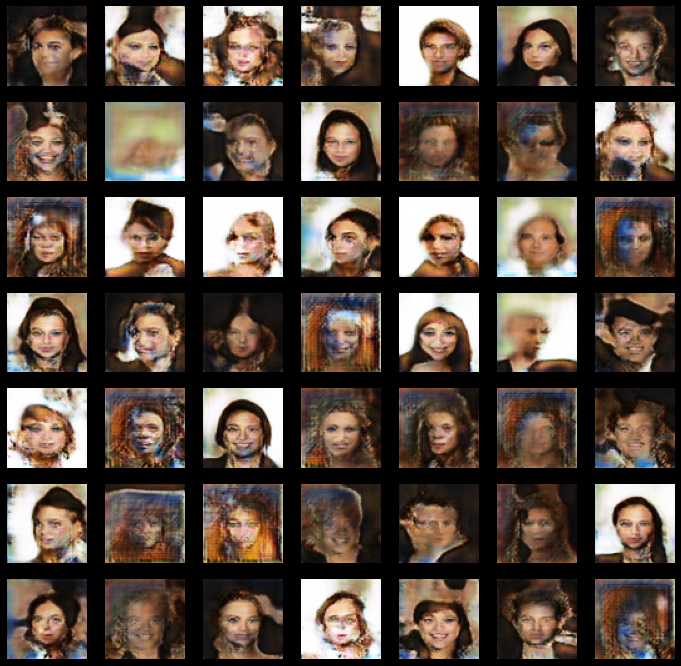

Generator Loss: 16.585 | Critic Loss: -2.046
Time For Epoch 22: 2m 25.42s
Remaining Time: 11h 11m 11.65s


KeyboardInterrupt: 

In [18]:
train(dataset, 300)

Prepare plot data

In [14]:
def get_poly_curve(y_values):
  x = np.arange(len(y_values))
  y = np.array(y_values)
  curve = np.polyfit(x, y, 2)
  poly_y = np.sum([a * x ** (2 - i) for i, a in enumerate(curve)], axis=0)
  return x, poly_y

generator_curve_x, generator_curve_y = get_poly_curve(generator_losses)
critic_curve_x, critic_curve_y = get_poly_curve(critic_losses)

Plot losses

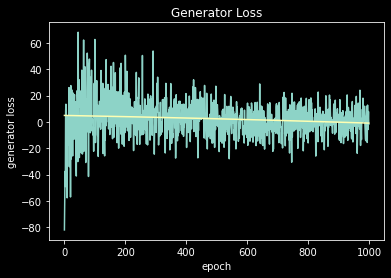

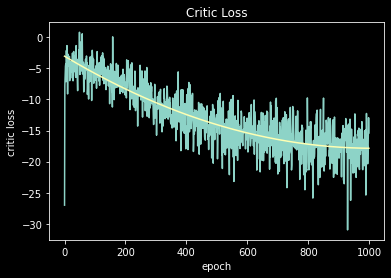

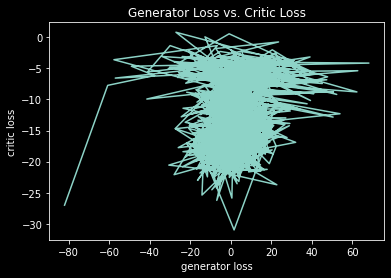

In [15]:
# plot generator loss
plt.plot(generator_losses)
plt.plot(generator_curve_x, generator_curve_y)
plt.title('Generator Loss')
plt.xlabel('epoch')
plt.ylabel('generator loss')
plt.show()

# plot critic loss
plt.plot(critic_losses)
plt.plot(critic_curve_x, critic_curve_y)
plt.title('Critic Loss')
plt.xlabel('epoch')
plt.ylabel('critic loss')
plt.show()

# show zero-sum
plt.plot(generator_losses, critic_losses)
plt.title('Generator Loss vs. Critic Loss')
plt.xlabel('generator loss')
plt.ylabel('critic loss')
plt.show()

Save generator

In [ ]:
mkdir('saved_generators/')
models.save_model(generator, f'saved_generators/{dataset_name}')

Turn training progress images into gif

In [84]:
skip_size = 5

with imageio.get_writer(f'gifs/{dataset_name}.gif', mode='I') as writer:
  filenames = sorted(glob.glob(f'output_images/{dataset_name}/image*.png'))
  for i in range(0, len(filenames), skip_size):
    writer.append_data(imageio.imread(filenames[i]))

# Results

Load generator

In [ ]:
generator = models.load(f'saved_generators/greek_coins')

Generate images

In [ ]:
num_examples = 36

noise = tf.random.normal([num_examples, noise_dim])
generated = generator(noise)

fig = plt.figure(figsize=(12, 12))
for i in range(num_examples):
  grid_size = int(np.ceil(np.sqrt(num_examples)))
  fig.add_subplot(grid_size, grid_size, i + 1)
  plt.imshow(generated[i] * 0.5 + 0.5)
  plt.axis('off')